In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa

from shapely import geometry

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import contextily as ctx
import py3dep

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

from constants import tol

In [2]:
data_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar')
ncs_dir = data_dir.joinpath('ncs')
ds = xr.open_dataset(ncs_dir.joinpath('final_insitu.nc'))

insitu = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/all_difference.parq')
insitu = gpd.GeoDataFrame(insitu, geometry = gpd.points_from_xy(insitu.lon, insitu.lat), crs="EPSG:4326")
interval = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/storm_boards.parq')
interval = gpd.GeoDataFrame(interval, geometry = gpd.points_from_xy(interval.longitude, interval.latitude), crs="EPSG:4326")

In [5]:
# lowman summit
lowman_bounds = -115.34, 44.18, -115.17, 44.33

hs = py3dep.get_map('Hillshade Gray', geometry = geometry.box(*lowman_bounds), resolution = 90, geo_crs = 'EPSG:4326', crs = 'EPSG:4326')

2021-01-27T23:55:00.000000000
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
2021-02-03T19:55:00.000000000
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


Text(0.5, 0.98, 'Comparison of SNOWMODEL and UAVSAR SWE Changes')

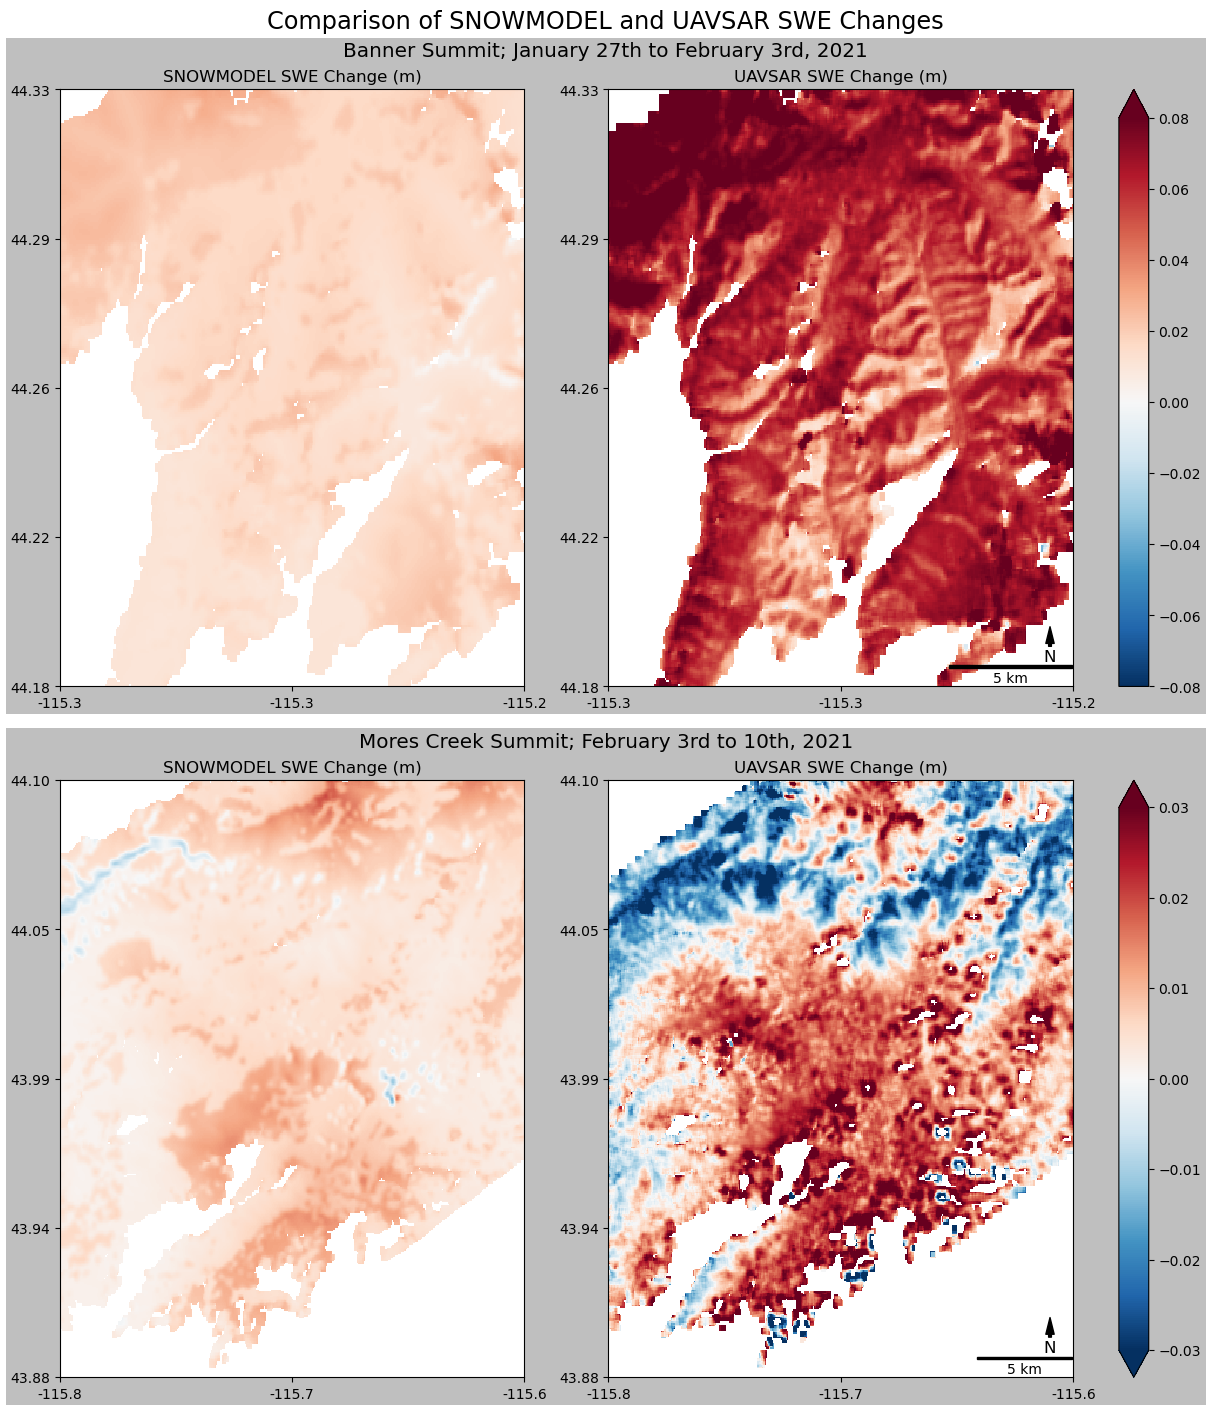

In [14]:
# lowman summit
lowman_bounds = -115.34, 44.18, -115.17, 44.33

# jan 27 - feb 3 2021
t = '2021-01-27T23:55:00.000000000' #'2021-02-03T19:55:00.000000000' # 2021-01-27T23:55:00.000000000

# mores creek summit
mores_bounds = -115.83, 43.88, -115.61, 44.1

# feb 3-10 2021
t = '2021-02-03T19:55:00.000000000' # 2021-01-27T23:55:00.000000000

fig = plt.figure(figsize=(12, 14), layout='constrained')
subfigs = fig.subfigures(2, 1, wspace=0.07)
axsTop = subfigs[0].subplots(1, 2)
axsBottom = subfigs[1].subplots(1, 2)

for bounds, t, axes, vlims in zip([lowman_bounds, mores_bounds], ['2021-01-27T23:55:00.000000000', '2021-02-03T19:55:00.000000000'], [axsTop, axsBottom], [[-0.08,0.08],[-0.03, 0.03]]):
    print(t)
    vmin, vmax = vlims

    xmin, ymin, xmax, ymax = bounds
    ds_t = ds.sel(x = slice(xmin, xmax), y = slice(ymax, ymin))
    ds_t = ds_t.isel(x = slice(0, -1, 10), y = slice(0, -1, 10))
    ds_t = ds_t.sel(time1 = t)

    # get insitu
    insitu_t = insitu.cx[xmin:xmax, ymin:ymax]
    insitu_t = insitu_t.loc[insitu_t.time1 == t]

    # atmospheric correction
    ds_t['unw_atm'] = ds_t['unw'] - ds_t['delay']

    # get sd change from gunnerison
    den = insitu_t[['t1_density', 't2_density']].mean(axis = 1).values[0]
    unw_d_swe = depth_from_phase((ds_t['unw_atm']), ds_t['inc'], density = den) * den / 997
    # unw_d_swe = unw_d_swe.assign_attrs(long_name = 'UAVSAR Change in SWE')
    # unw_d_swe = unw_d_swe.assign_attrs(units = 'meters')

    # smooth
    unw_d_swe = unw_d_swe.rolling(x = 4, y = 4, min_periods = 1).mean()

    # plot
    unw_d_swe.plot(ax = axes[1], vmax = vmax, vmin = vmin, cmap = 'RdBu_r') #vmax = 0.03, vmin = -0.03

    # calculate retrieved, modeled, and in situ swe change
    for i, r in insitu_t.iterrows():
        n = 2
        x_slice = slice(r.geometry.x - n*tol, r.geometry.x + n*tol)
        y_slice = slice(r.geometry.y + n*tol, r.geometry.y - n*tol)
        insitu_t.loc[i, 'model_dSWE'] = ds_t['model_d_swe'].sel(x = x_slice, y = y_slice).mean(skipna = True).data.ravel()[0]
        insitu_t.loc[i, 'uavsar_dSWE'] = unw_d_swe.sel(x = x_slice, y = y_slice).mean(skipna = True).data.ravel()[0]

    # was correcting model to insitu but stopped
    # insitu_model_correct = np.mean((insitu_t['swe']/ insitu_t['model_dSWE']).values)
    # plot modeled
    ds_t['model_d_swe'].where(~ds_t['unw'].isnull()).rolling(x = 4, y = 4, min_periods = 1).mean().plot(ax = axes[0], vmax = vmax, vmin = vmin, cmap ='RdBu_r', add_colorbar = False)

    for ax in axes:
        ax.set_xlabel('')
        ax.set_ylabel('')
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.linspace(start, end, 3))
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

        # ax.set_ylim(bottom = 43.88)
        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.linspace(start, end, 5))
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

        # mores_interval_t.plot(color = 'black', ax = ax, marker = 'x') #  cmap = 'RdBu_r',vmax = 0.03, vmin = -0.03

        # ctx.add_basemap(ax, crs = 'EPSG:4326')

    axes[0].set_title('SNOWMODEL SWE Change (m)')
    axes[1].set_title('UAVSAR SWE Change (m)')

    # scale bar
    scalebar = AnchoredSizeBar(axes[1].transData,
                            tol*50, '5 km', 'lower right', 
                            pad=tol,
                            color='black',
                            frameon=False,
                            size_vertical=tol/1)

    axes[1].add_artist(scalebar)

    # n arrow
    x, y, arrow_length = 0.95, 0.1, 0.05
    axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=2, headwidth=6),
                ha='center', va='center', fontsize=12,
                xycoords=axes[1].transAxes)

# plt.tight_layout()

subfigs[1].suptitle('Mores Creek Summit; February 3rd to 10th, 2021', fontsize='x-large')
subfigs[0].suptitle('Banner Summit; January 27th to February 3rd, 2021', fontsize='x-large')

for subfig in subfigs:
    subfig.set_facecolor('0.75')

fig.suptitle('Comparison of SNOWMODEL and UAVSAR SWE Changes', fontsize='xx-large')


In [3]:
# mores creek summit
xmin, ymin, xmax, ymax = -115.83, 43.84, -115.61, 44.1

# feb 3-10 2021
t = '2021-02-03T19:55:00.000000000' # 2021-01-27T23:55:00.000000000

mores = ds[['unw','cor','dem','int_phase','inc','delay','tree_perc','cum_melt','model_swe','model_d_swe']]
mores = mores.sel(x = slice(xmin, xmax), y = slice(ymax, ymin))
mores = mores.isel(x = slice(0, -1, 10), y = slice(0, -1, 10))

ds_t = mores.sel(time1 = t).load()

mores_insitu = insitu.cx[xmin:xmax, ymin:ymax]
mores_interval = interval.cx[xmin:xmax, ymin:ymax]

insitu_mores_t = mores_insitu.loc[mores_insitu.time1 == t]
mores_interval_t = mores_interval.set_index('date_t1').sort_index()[pd.to_datetime(t) - pd.Timedelta('3 days'):pd.to_datetime(t) + pd.Timedelta('3 days')]
mores_interval_t = mores_interval_t.reset_index()

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


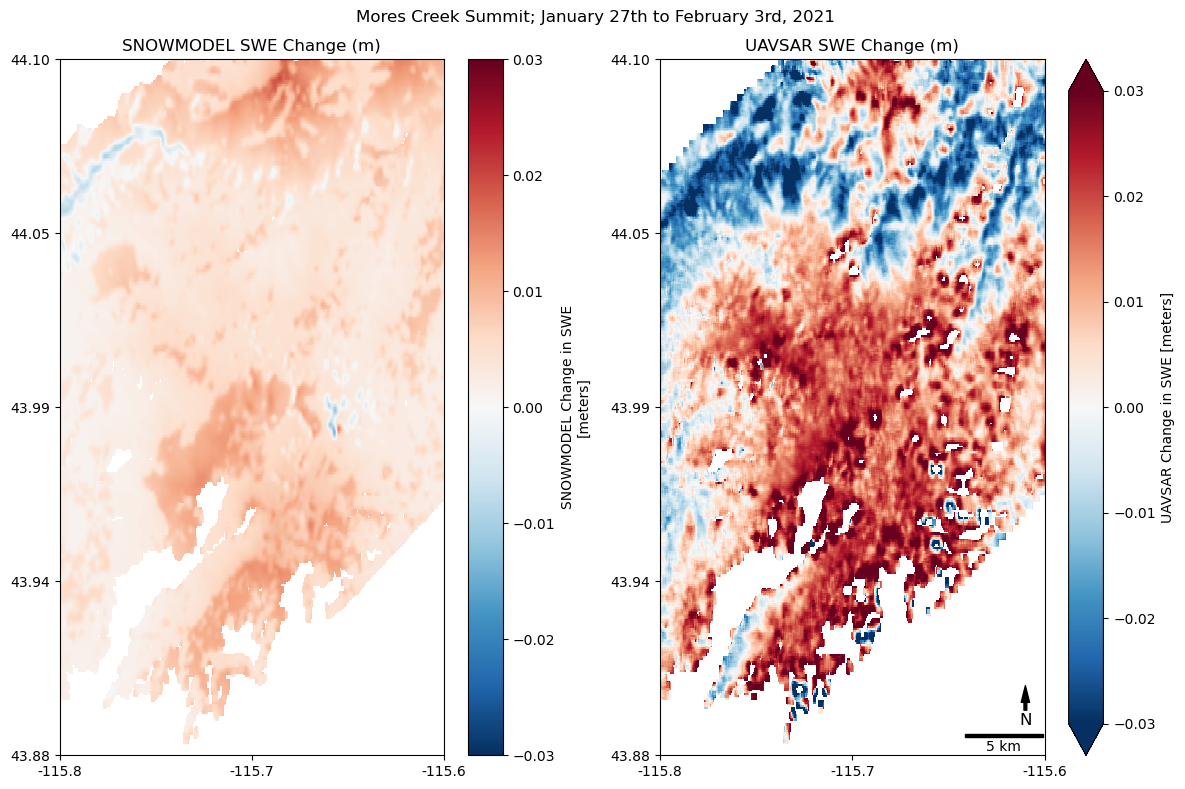

In [5]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))

# atmospheric correction
ds_t['unw_atm'] = ds_t['unw'] - ds_t['delay']

# pin phase to snotel (not used)
# snotel_phase = phase_from_depth(insitu_mores_t['dSWE'] * 997 /den, insitu_mores_t['inc'], density =  den).values[0]
# ds_t['unw_atm'] = ds_t['unw_atm'] - (ds_t['unw_atm'].mean() - snotel_phase)

# get sd change from gunnerison
den = insitu_mores_t[['t1_density', 't2_density']].mean(axis = 1).values[0]
unw_d_swe = depth_from_phase((ds_t['unw_atm']), ds_t['inc'], density = den) * den / 997
unw_d_swe = unw_d_swe.assign_attrs(long_name = 'UAVSAR Change in SWE')
unw_d_swe = unw_d_swe.assign_attrs(units = 'meters')

# smooth
unw_d_swe = unw_d_swe.rolling(x = 4, y = 4, min_periods = 1).mean()

# plot
unw_d_swe.plot(ax = axes[1], vmax = 0.03, vmin = -0.03, cmap = 'RdBu_r') #vmax = 0.03, vmin = -0.03

# calculate retrieved, modeled, and in situ swe change
for i, r in mores_interval_t.iterrows():
    n = 2
    x_slice = slice(r.geometry.x - n*tol, r.geometry.x + n*tol)
    y_slice = slice(r.geometry.y + n*tol, r.geometry.y - n*tol)
    mores_interval_t.loc[i, 'model_dSWE'] = ds_t['model_d_swe'].sel(x = x_slice, y = y_slice).mean(skipna = True).data.ravel()[0]
    mores_interval_t.loc[i, 'uavsar_dSWE'] = unw_d_swe.sel(x = x_slice, y = y_slice).mean(skipna = True).data.ravel()[0]

# was correcting model to insitu but stopped
insitu_model_correct = np.mean((mores_interval_t['swe']/ mores_interval_t['model_dSWE']).values)
# plot modeled
ds_t['model_d_swe'].where(~ds_t['unw'].isnull()).rolling(x = 4, y = 4, min_periods = 1).mean().plot(ax = axes[0], vmax = 0.03, vmin = -0.03, cmap ='RdBu_r')

for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.linspace(start, end, 3))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    ax.set_ylim(bottom = 43.88)
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.linspace(start, end, 5))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # mores_interval_t.plot(color = 'black', ax = ax, marker = 'x') #  cmap = 'RdBu_r',vmax = 0.03, vmin = -0.03

    # ctx.add_basemap(ax, crs = 'EPSG:4326')

axes[0].set_title('SNOWMODEL SWE Change (m)')
axes[1].set_title('UAVSAR SWE Change (m)')

# scale bar
scalebar = AnchoredSizeBar(ax.transData,
                           tol*50, '5 km', 'lower right', 
                           pad=tol/1000,
                           color='black',
                           frameon=False,
                           size_vertical=tol/1)

axes[1].add_artist(scalebar)

# n arrow
x, y, arrow_length = 0.95, 0.1, 0.05
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=2, headwidth=6),
            ha='center', va='center', fontsize=12,
            xycoords=axes[1].transAxes)

plt.suptitle('Mores Creek Summit; January 27th to February 3rd, 2021')

plt.tight_layout()

In [40]:
# mores creek summit
xmin, ymin, xmax, ymax = -115.83, 43.84, -115.61, 44.1

# jan 27 - feb 3 2021
t = '2021-01-27T23:55:00.000000000' #'2021-02-03T19:55:00.000000000' # 2021-01-27T23:55:00.000000000

mores = ds[['unw','cor','dem','int_phase','inc','delay','tree_perc','cum_melt','model_swe','model_d_swe']]
mores = mores.sel(x = slice(xmin, xmax), y = slice(ymax, ymin))
mores = mores.isel(x = slice(0, -1, 10), y = slice(0, -1, 10))

ds_t = mores.sel(time1 = t).load()

mores_insitu = insitu.cx[xmin:xmax, ymin:ymax]
mores_interval = interval.cx[xmin:xmax, ymin:ymax]

insitu_mores_t = mores_insitu.loc[mores_insitu.time1 == t]
mores_interval_t = mores_interval.set_index('date_t1').sort_index()[pd.to_datetime(t) - pd.Timedelta('3 days'):pd.to_datetime(t) + pd.Timedelta('3 days')]
mores_interval_t = mores_interval_t.reset_index()

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


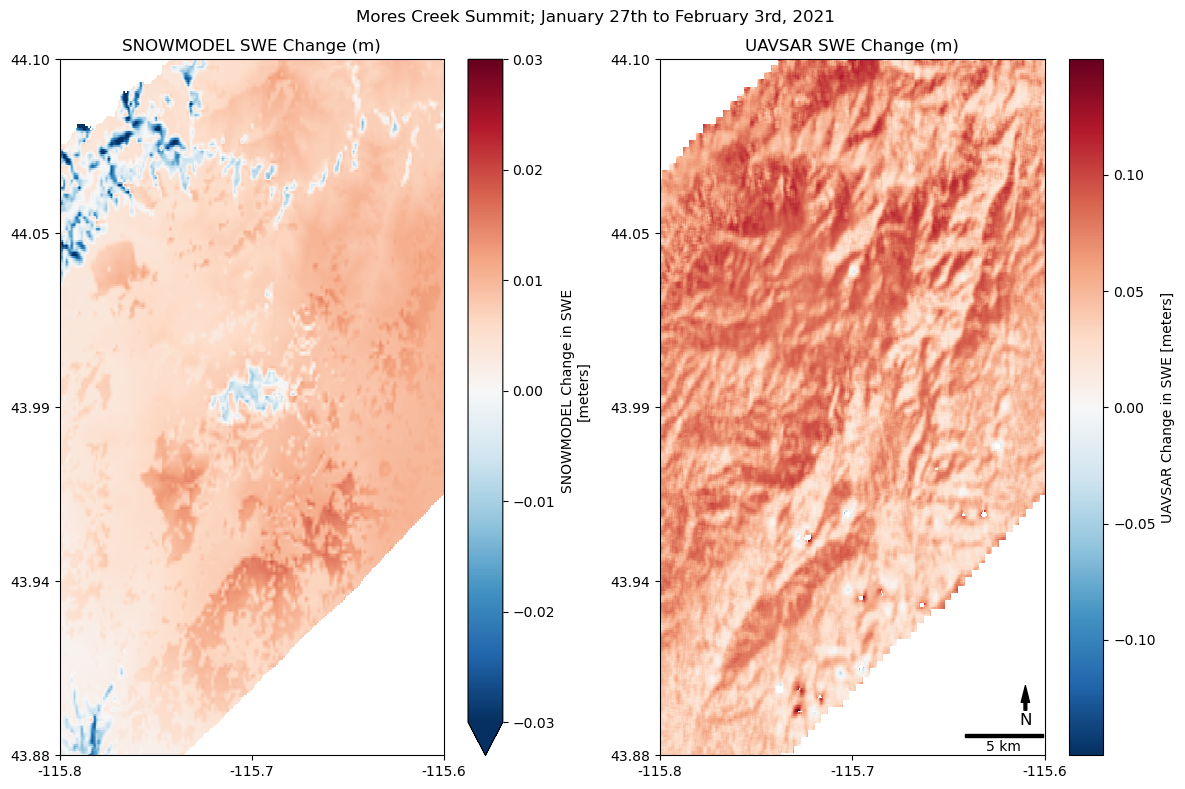

In [45]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))
ds_t['model_d_swe'].where(~ds_t['int_phase'].isnull()).plot(ax = axes[0], vmax = 0.03, vmin = -0.03, cmap ='RdBu_r')

den = insitu_mores_t[['t1_density', 't2_density']].mean(axis = 1).values[0]
unw_d_swe = depth_from_phase((ds_t['int_phase'] - ds_t['delay']), ds_t['inc'], density = den) * den / 997
unw_d_swe = unw_d_swe.assign_attrs(long_name = 'UAVSAR Change in SWE')
unw_d_swe = unw_d_swe.assign_attrs(units = 'meters')

unw_d_swe.rolling(x = 4, y = 4, min_periods = 1).mean().plot(ax = axes[1], cmap = 'RdBu_r') #vmax = 0.03, vmin = -0.03


for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.linspace(start, end, 3))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    ax.set_ylim(bottom = 43.88)
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.linspace(start, end, 5))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # mores_interval_t.plot(color = 'black', ax = ax, marker = 'x') #  cmap = 'RdBu_r',vmax = 0.03, vmin = -0.03

    # ctx.add_basemap(ax, crs = 'EPSG:4326')

axes[0].set_title('SNOWMODEL SWE Change (m)')
axes[1].set_title('UAVSAR SWE Change (m)')

scalebar = AnchoredSizeBar(ax.transData,
                           tol*50, '5 km', 'lower right', 
                           pad=tol/1000,
                           color='black',
                           frameon=False,
                           size_vertical=tol/1)

axes[1].add_artist(scalebar)

x, y, arrow_length = 0.95, 0.1, 0.05
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=2, headwidth=6),
            ha='center', va='center', fontsize=12,
            xycoords=axes[1].transAxes)

plt.suptitle('Mores Creek Summit; January 27th to February 3rd, 2021')

plt.tight_layout()

In [137]:
# lowman summit
xmin, ymin, xmax, ymax = -115.34, 44.18, -115.17, 44.33

# jan 27 - feb 3 2021
t = '2021-01-27T23:55:00.000000000' #'2021-02-03T19:55:00.000000000' # 2021-01-27T23:55:00.000000000

mores = ds[['unw','cor','dem','int_phase','inc','delay','tree_perc','cum_melt','model_swe','model_d_swe']]
mores = mores.sel(x = slice(xmin, xmax), y = slice(ymax, ymin))
mores = mores.isel(x = slice(0, -1, 10), y = slice(0, -1, 10))

ds_t = mores.sel(time1 = t).load()

mores_insitu = insitu.cx[xmin:xmax, ymin:ymax]
mores_interval = interval.cx[xmin:xmax, ymin:ymax]

insitu_mores_t = mores_insitu.loc[mores_insitu.time1 == t]
insitu_mores_t = insitu_mores_t[insitu_mores_t.datasource == 'NRCS']

mores_interval_t = mores_interval.set_index('date_t1').sort_index()[pd.to_datetime(t) - pd.Timedelta('3 days'):pd.to_datetime(t) + pd.Timedelta('3 days')]
mores_interval_t = mores_interval_t.reset_index()

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
<xarray.DataArray 'unw_atm' ()>
array(3.66791595)
Coordinates:
    heading  <U3 '232'
    time1    datetime64[ns] 2021-01-27T23:55:00
    time2    datetime64[ns] 2021-02-03T19:55:00
<xarray.DataArray 'unw_atm' ()>
array(3.65525394)
Coordinates:
    heading  <U3 '232'
    time1    datetime64[ns] 2021-01-27T23:55:00
    time2    datetime64[ns] 2021-02-03T19:55:00
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


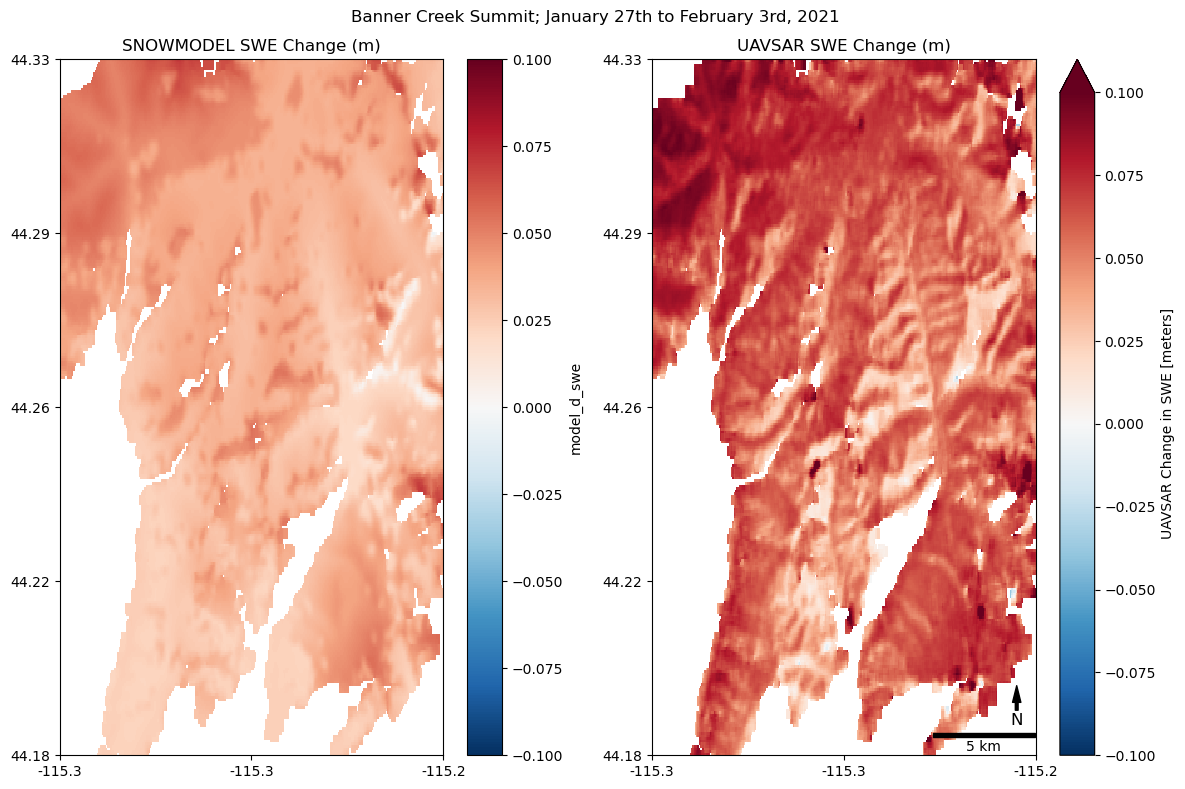

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))

# atmospheric correction
ds_t['unw_atm'] = ds_t['unw'] - ds_t['delay']

# pin phase to snotel (not used)
# snotel_phase = phase_from_depth(insitu_mores_t['dSWE'] * 997 /den, insitu_mores_t['inc'], density =  den).values[0]
# ds_t['unw_atm'] = ds_t['unw_atm'] - (ds_t['unw_atm'].mean() - snotel_phase)

# get sd change from gunnerison
den = insitu_mores_t[['t1_density', 't2_density']].mean(axis = 1).values[0]
unw_d_swe = depth_from_phase((ds_t['unw_atm']), ds_t['inc'], density = den) * den / 997
unw_d_swe = unw_d_swe.assign_attrs(long_name = 'UAVSAR Change in SWE')
unw_d_swe = unw_d_swe.assign_attrs(units = 'meters')

# smooth
unw_d_swe = unw_d_swe.rolling(x = 4, y = 4, min_periods = 1).mean()

# plot
unw_d_swe.plot(ax = axes[1], vmax = 0.1, vmin = -0.1, cmap = 'RdBu_r') #vmax = 0.03, vmin = -0.03

# calculate retrieved, modeled, and in situ swe change
for i, r in mores_interval_t.iterrows():
    n = 2
    x_slice = slice(r.geometry.x - n*tol, r.geometry.x + n*tol)
    y_slice = slice(r.geometry.y + n*tol, r.geometry.y - n*tol)
    mores_interval_t.loc[i, 'model_dSWE'] = ds_t['model_d_swe'].sel(x = x_slice, y = y_slice).mean(skipna = True).data.ravel()[0]
    mores_interval_t.loc[i, 'uavsar_dSWE'] = unw_d_swe.sel(x = x_slice, y = y_slice).mean(skipna = True).data.ravel()[0]

# was correcting model to insitu but stopped
insitu_model_correct = np.mean((mores_interval_t['swe']/ mores_interval_t['model_dSWE']).values)
# plot modeled
ds_t['model_d_swe'].where(~ds_t['unw'].isnull()).rolling(x = 4, y = 4, min_periods = 1).mean().plot(ax = axes[0], vmax = 0.1, vmin = -0.1, cmap ='RdBu_r')

for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.linspace(start, end, 3))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    # ax.set_ylim(bottom = 43.88)
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.linspace(start, end, 5))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # mores_interval_t.plot(color = 'black', ax = ax, marker = 'x') #  cmap = 'RdBu_r',vmax = 0.03, vmin = -0.03

    # ctx.add_basemap(ax, crs = 'EPSG:4326')

axes[0].set_title('SNOWMODEL SWE Change (m)')
axes[1].set_title('UAVSAR SWE Change (m)')

# scale bar
scalebar = AnchoredSizeBar(ax.transData,
                           tol*50, '5 km', 'lower right', 
                           pad=tol/1000,
                           color='black',
                           frameon=False,
                           size_vertical=tol/1)

axes[1].add_artist(scalebar)

# n arrow
x, y, arrow_length = 0.95, 0.1, 0.05
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=2, headwidth=6),
            ha='center', va='center', fontsize=12,
            xycoords=axes[1].transAxes)

plt.suptitle('Banner Creek Summit; January 27th to February 3rd, 2021')

plt.tight_layout()

In [134]:
for i, r in mores_interval_t.iterrows():
    n = 2
    x_slice = slice(r.geometry.x - n*tol, r.geometry.x + n*tol)
    y_slice = slice(r.geometry.y + n*tol, r.geometry.y - n*tol)
    mores_interval_t.loc[i, 'model_dSWE'] = ds_t['model_d_swe'].sel(x = x_slice, y = y_slice).mean(skipna = True).data.ravel()[0]
    mores_interval_t.loc[i, 'uavsar_dSWE'] = unw_d_swe.sel(x = x_slice, y = y_slice).mean(skipna = True).data.ravel()[0]

<Axes: xlabel='swe', ylabel='uavsar_dSWE'>

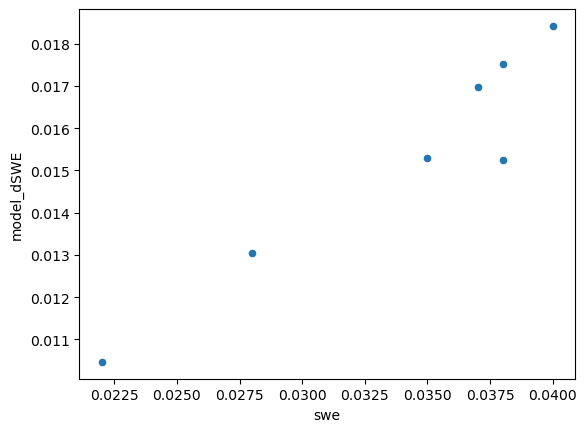

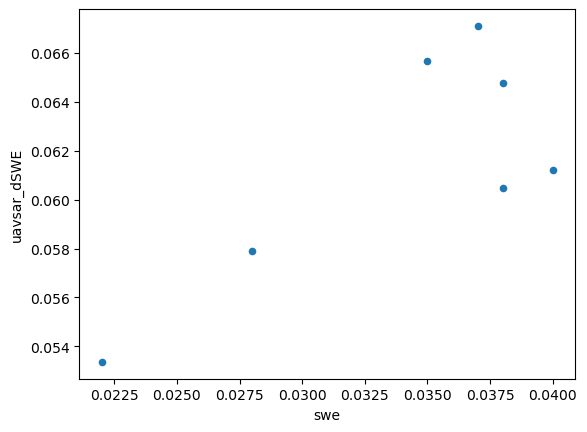

In [135]:
# fig, ax = plt.subplots()
mores_interval_t.plot.scatter(x = 'swe', y = 'model_dSWE')
mores_interval_t.plot.scatter(x = 'swe', y = 'uavsar_dSWE')

In [66]:
# lowman summit
xmin, ymin, xmax, ymax = -115.34, 44.18, -115.17, 44.33

# jan 27 - feb 3 2021
t = '2021-02-03T19:55:00.000000000' #'2021-02-03T19:55:00.000000000' # 2021-01-27T23:55:00.000000000

mores = ds[['unw','cor','dem','int_phase','inc','delay','tree_perc','cum_melt','model_swe','model_d_swe']]
mores = mores.sel(x = slice(xmin, xmax), y = slice(ymax, ymin))
mores = mores.isel(x = slice(0, -1, 10), y = slice(0, -1, 10))

ds_t = mores.sel(time1 = t).load()

mores_insitu = insitu.cx[xmin:xmax, ymin:ymax]
mores_interval = interval.cx[xmin:xmax, ymin:ymax]

insitu_mores_t = mores_insitu.loc[mores_insitu.time1 == t]
mores_interval_t = mores_interval.set_index('date_t1').sort_index()[pd.to_datetime(t) - pd.Timedelta('3 days'):pd.to_datetime(t) + pd.Timedelta('3 days')]
mores_interval_t = mores_interval_t.reset_index()

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


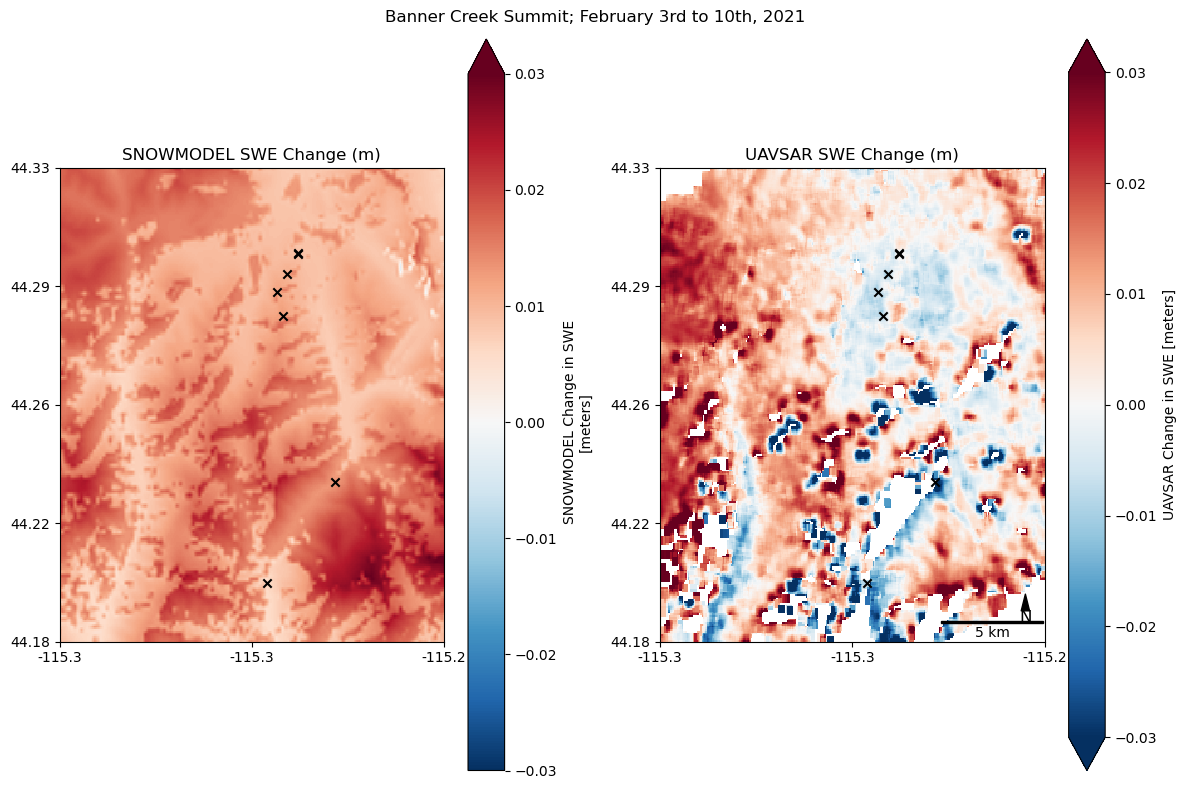

In [89]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))
ds_t['model_d_swe'].plot(ax = axes[0], vmax = 0.03, vmin = -0.03, cmap ='RdBu_r') #.where(~ds_t['unw'].isnull())

den = insitu_mores_t[['t1_density', 't2_density']].mean(axis = 1).values[0]
unw_d_swe = depth_from_phase((ds_t['unw'] - ds_t['delay']), ds_t['inc'], density = den) * den / 997
unw_d_swe = unw_d_swe.assign_attrs(long_name = 'UAVSAR Change in SWE')
unw_d_swe = unw_d_swe.assign_attrs(units = 'meters')

unw_d_swe.where(ds_t['cor'] > 0.5).rolling(x = 5, y = 5, min_periods = 1).mean().plot(ax = axes[1], cmap = 'RdBu_r', vmax = 0.03, vmin = -0.03)


for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.linspace(start, end, 3))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    # ax.set_ylim(bottom = 43.88)
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.linspace(start, end, 5))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    mores_interval_t.plot(color = 'black', ax = ax, marker = 'x') #  cmap = 'RdBu_r',vmax = 0.03, vmin = -0.03

    # ctx.add_basemap(ax, crs = 'EPSG:4326')

axes[0].set_title('SNOWMODEL SWE Change (m)')
axes[1].set_title('UAVSAR SWE Change (m)')

scalebar = AnchoredSizeBar(ax.transData,
                           tol*50, '5 km', 'lower right', 
                           pad=tol/1000,
                           color='black',
                           frameon=False,
                           size_vertical=tol/1)

axes[1].add_artist(scalebar)

x, y, arrow_length = 0.95, 0.1, 0.05
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=2, headwidth=6),
            ha='center', va='center', fontsize=12,
            xycoords=axes[1].transAxes)

plt.suptitle('Banner Creek Summit; February 3rd to 10th, 2021')

plt.tight_layout()